# Import Data

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import rfpimp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [129]:
x_train=pd.read_csv("/Users/xinyuewang/Desktop/Electricity Price Predict/X_train_NHkHMNU.csv").set_index('ID').sort_values(by='DAY_ID')
y_train=pd.read_csv("/Users/xinyuewang/Desktop/Electricity Price Predict/y_train_ZAN5mwg.csv").set_index('ID')
x_test=pd.read_csv("/Users/xinyuewang/Desktop/Electricity Price Predict/X_test_final.csv").set_index('ID')

x_train = pd.get_dummies(x_train, columns=['COUNTRY'])  # One Hot Encoding for each country

#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
y_train = x_train.join(y_train)[['TARGET']] # Align the ID column of X and y
x_test = pd.get_dummies(x_test, columns=['COUNTRY']) # One Hot Encoding for each country


# Data Preparation
There are some missing values in the dataset, so here we use the linear interpolation method to fill the missing value and use forward and backward fill as supplementary.

In [131]:
x_train.interpolate(method='polynomial',order=2, inplace=True)
x_test.interpolate(method='polynomial',order=2, inplace=True)
x_train = x_train.fillna(method='ffill')  # Forward Fill Missing Data
x_train = x_train.fillna(method='bfill')  # Backward Fill introduces lookahead bias
x_test = x_test.fillna(method='ffill')  # Forward Fill Missing Data
x_test = x_test.fillna(method='bfill')  # Backward Fill introduces lookahead bias

y_train_clean = y_train['TARGET']


# Missing values check
To make sure that there is no missing value on the training data set.

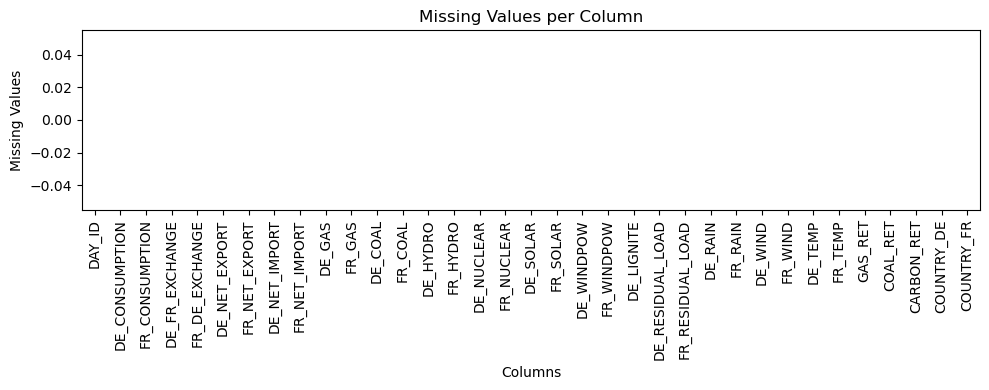

In [132]:
missing_values = x_test.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Random Forest 

In this part, we will use the random forest method to predict electricity price. We will follow a simple workflow as CART: tune the hyperparameters and then train the final model.

Random forest has two groups of hyperparameters:

1. The hyperparameters of decision trees, such as max_depth, min_samples_split;
2. The configurations of RF, such as the number of trees (called **n_estimators**). By default, **n_estimators** is set as 100. Some intuition is that the larger n_estimators, the more stable the model performance and the longer computing time. This is because the computing time is a linear function of the number of trees.

The default value of 100 trees is good for most applications, so we don't tune this hyperparameter here.

As with CART, we will focus on the tuning of max_depth and min_samples_split.


In [118]:


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

def RandomForestRegressorCrossValidationMetricScore(X_clean, Y_clean):
    """ Cross Validation for Metric Score: Maximising Spearman Correlation"""
    
    # Create a scorer from the custom metric function
    spearman_scorer = make_scorer(metric_train, greater_is_better=True)
    
    # Define your parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Initialize your model
    rf_reg = RandomForestRegressor(random_state=42)
    
    # Setup GridSearchCV with your custom scorer
    cv_method = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5,
                             scoring=spearman_scorer, verbose=2, n_jobs=-1)
    
    # Assuming X_clean and Y_clean are already defined and preprocessed
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.20, random_state=42)
    
    # Fit the model to find the best parameters
    cv_method.fit(X_train, y_train)
    
    # Best parameters found
    print("Best parameters found: ", cv_method.best_params_)
    
    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)
    
    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))
    
    training_prediction = cv_method.predict(X_clean)
    
    # Calculate Spearman correlation on the test set
    test_spearman_correlation = metric_train(y_test, y_pred) 
    print('Test set Spearman correlation: {:.1f}%'.format(test_spearman_correlation))
    
    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction": training_prediction,
        "Metric Score": test_spearman_correlation,
        "model": cv_method
    }
    return result



Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test set RMSE: 0.98
Test set Spearman correlation: 9.6%


In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

def RandomForestRegressorCrossValidationMSE(X_clean, Y_clean):
    """ Return the Cross Validated Parameters for RandomForestRegressor for MSE"""
    
    # X_clean and Y_clean must be processed already
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_reg = RandomForestRegressor(random_state=42)

    # GridSearchCV with the scoring minimizing MSE
    cv_method = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5,
                             scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))

    training_prediction = cv_method.predict(X_clean)

    print('Cross Validated Model MSE for the train set: {:.2f}'.format(mean_squared_error(training_prediction, Y_clean)))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction": training_prediction,
        "Metric Score": mean_squared_error(training_prediction, Y_clean),
        "model": cv_method
    }
    return result


X_clean = x_train
Y_clean = y_train['TARGET']

CV_RF_MSE = RandomForestRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test set RMSE: 0.95
Cross Validated Model MSE for the train set: 0.71


In [135]:
X_test_clean = x_test


cross_validated_model = pd.DataFrame()
cross_validated_model['ID'] = x_test.index.to_list()
cross_validated_model['TARGET'] = CV_RF_MSE['model'].predict(x_test)
cross_validated_model.to_csv('/Users/xinyuewang/Desktop/Electricity Price Predict/cross_validated_model.csv', index=False)


# Feature Engineering

                  Importance
Feature                     
DE_LIGNITE          0.011035
DE_FR_EXCHANGE      0.006007
FR_COAL             0.005769
DE_NUCLEAR          0.005404
DE_WIND             0.005376
DAY_ID              0.004963
DE_TEMP             0.004085
FR_DE_EXCHANGE      0.002710
FR_NUCLEAR          0.002183
GAS_RET             0.001989
FR_WIND             0.001835
FR_RESIDUAL_LOAD    0.001633
FR_RAIN             0.001453
FR_SOLAR            0.001354
DE_NET_IMPORT       0.001289
FR_GAS              0.001190
DE_SOLAR            0.000898
FR_HYDRO            0.000557
FR_TEMP             0.000081
DE_GAS             -0.000038
DE_NET_EXPORT      -0.000216
FR_CONSUMPTION     -0.000222
FR_NET_IMPORT      -0.000734
ID                 -0.000981
FR_NET_EXPORT      -0.001227
COAL_RET           -0.001277
FR_WINDPOW         -0.002626
DE_COAL            -0.003436
DE_RAIN            -0.003805
CARBON_RET         -0.004526
DE_HYDRO           -0.005240
DE_CONSUMPTION     -0.005501
DE_RESIDUAL_LO

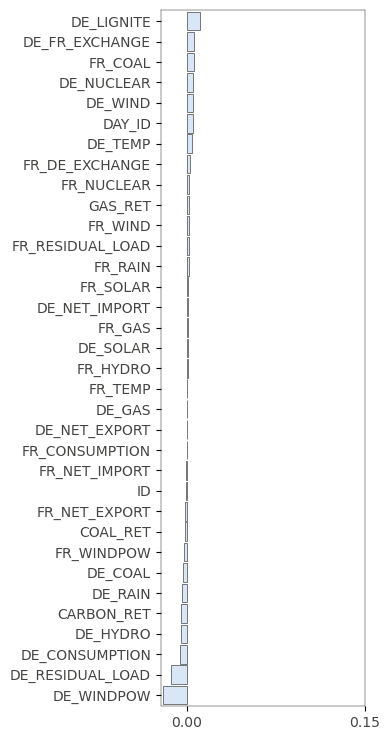

In [83]:

imp = rfpimp.importances(rf_final, x_test_clean, y_test_clean)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

